# Preliminary instruction

To follow the code in this chapter, the `yfinance` package must be installed in your environment. If you do not have this installed yet, review Chapter 4 for instructions on how to do so.

# SCREENING ACROSS THE S&P 500 INDEX

### Floor/Ceiling regime definition

Unlike the previous methodologies, the floor/ceiling regime definitionis computationally intense. It is in two parts:

1. Swing detection is a succession of functions. It is broadly split in two parts:
    1. historical swing detection: all the swings leading up to the latest one
        1. historical_swings: this uses find_peaks to find small peaks. This function loops over series coming from the hilo alternation function to zoom out
        2. hilo alternation: this function simply reduces series to alternate highs and lows
    2. latest swing detection: rapid fire functions to detect the latest swing in real time
        1. cleanup_latest_swing: Eliminate false positives Swing High/Low last swing
        2. latest_swing_variables: Set-up arguments for latest swing High or Low
        3. test_distance: noise filter: removes short amplitude noise
        4. average_true_range: classic volatility in 1 line of code
        5. retest_swing: retest method
        6. retracement_swing: alternative swing detection: retracement from high/low
  
  
2. Floor/ceiling regime definition uses swings detected above
    1. Classic regime definition:
        1. Bullish: (swing low - bottom)/std > threshold
        2. Bearish: (swing high - top)/std < threshold
    2. Handling exception:
        1. Bearish: Low < swing low
        2. Bullish: High > swing high

### Swings and Regime summary functions

These two functions call the functions necessary to calculate the floor/ceiling.

1. swings: A simple toggle rel calculates either the absolute (rel = False) or the relative swings

2. regime: lvl refers to the swing levels used to calculate regime. For example, Hi2/Lo2 refers to level 2 swings (reduced twice), rH3/rL3 to relative level 3 etc.

### Graph combo

This verbose function visualises all the above regime definition methodologies

### New Functions to process data

Those two functions were not published earlier in the book.

1. yf_droplevel(batch_download,ticker)
The batch downoload returns a multiindex dataframe. This drops level from multiindex df to single stock level. 
    
2. last_row_dictionary(df)
    1. creates dictionary with last row
    2. when last row is N/A, creates additional column with date

### Control Panel

This is where all arguments and variables are centralised. Dissmeination of variables and arguments the file is a common source of error, hence the centralisation.

In [1]:
import json

with open('scanner_config.json') as fp:
    scanner_args = json.load(fp)

(
    website,
    start,
    end,
    vlty_n,
    dist_pct,
    retrace_pct,
    threshold,
    dgt,
    d_vol,
    r_vol,
    lvl,
    bm_ticker,
    bm_col,
    ccy_col,
    window,
    st,
    lt,
    save_ticker_df,
    save_last_row_df,
    save_regime_df
) = list(scanner_args.values())

fast = st
slow = lt

batch_size = 20
show_batch = True

web_df_cols = ['Symbol','Security','GICS Sector','GICS Sub-Industry']
regime_cols = [
    'rg','rrg',
    'smaC'+str(st)+str(lt),'smar'+str(st)+str(lt), 'boHL'+str(slow),
    'borr'+str(slow),'ttH'+str(fast)+'L'+str(slow),'ttr'+str(fast)+'r'+str(slow)
]
swings_cols = [
    'flr_dt','flr','clg_dt', 'clg', 'rg_ch',
    'Hi'+str(lvl)+'_dt','Hi'+str(lvl),'Lo'+str(lvl)+'_dt','Lo'+str(lvl),
    'rflr_dt', 'rflr', 'rclg_dt', 'rclg', 'rrg_ch',
    'rH'+str(lvl)+'_dt','rH'+str(lvl),'rL'+str(lvl)+'_dt','rL'+str(lvl)
]
symbol_cols = ['Symbol','date','Close']

last_row_df_cols = symbol_cols + ['score'] + regime_cols + swings_cols

### Download investment universe from website: Wikipedia

Read S&P500 page from Wikipedia, extract a tickers list
This line (tickers_list = tickers_list[:]) is used to slice the tickers list and avoid downloading data for the entire set each time

In [2]:
import pandas as pd

web_df = pd.read_html(website)[0]
web_df['GICS Sub-Industry'] = web_df['GICS Sub-Industry'].str.replace('&', 'and', regex=True)
tickers_list =  list(web_df['Symbol'])
tickers_list = tickers_list[:]
print('tickers_list',len(tickers_list))
web_df.head()

tickers_list 503


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting and Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


### Download & Process: the engine room

1. Benchmark download closing price & currency adjustment
2. dataframes and lists instantiation
3. loop size: number of iterations necessary to loop over the tickers_list
4. Outer loop:
    1. m,n: index along the batch_list
    2. batch_download: download using yfinance:
        1. print batch tickers
        2. donwload batch
        3. try/except: append failed list
    3. Second loop for every batch:
        1. droplevel to ticker level
        2. Calculate swings and regime: abs/rel
        3. Third loop: absolute/relative series:
            1. process regimes in absolute series
            2. reset variables to relative series and process regimes second time
        5. boolean save_ticker_df
    4. Create a dictionary with last row values. When last row value are N/A, add another key for the date of the last value, then find value
    5. append list of dictionary rows
5. create a dataframe last_row_df from dictionary
6. 'score' column: lateral sum of regime methods absolute & relative
7. join last_row_df with web_df
8. boolean save_regime_df
    


### Regime df heatmaps by sector and sub-industry

The Wikipedia page displays GICS Sectors and Sub-Industry. We group the regime_df by sectors, sub-industry and display

1. Top down bird's eye view GICS Sectors
2. Bottom up sub-industry
3. Sector (alphabetical order) and score (ascending order) to arbitrage sub-industries within sectors


In [3]:
from notes.scanner_engine import main

regime_df = main(**scanner_args)

[*********************100%***********************]  1 of 1 completed
benchmark               SP500  USD
Date                    
2023-03-22  3936.97    1
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
failed ['BRK.B', 'BF.B', 'GEHC']


In [4]:
# delta measures the difference between absolute and relative regimes
regime_df['delta'] = 0
regime_pairs = [('rg', 'rrg'), ('smaC50200', 'smar50200'), ('boHL200', 'borr200'), ('ttH50L200', 'ttr50r200')]
for absolute, relative in regime_pairs:
    delta = ((regime_df[absolute] - regime_df[relative]) * -1) / 2
    regime_df['delta'] = regime_df['delta'] + delta

regime_df['delta'] = regime_df['delta'] / len(regime_pairs)
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sector']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score').style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

,score,delta,rg,rrg,smaC50200,smar50200,boHL200,borr200,ttH50L200,ttr50r200
GICS Sector,,,,,,,,,,
Real Estate,-4,-0.04,-0.8,-0.7,0,-0.3,-0.2,-0.5,-0.7,-0.6
Utilities,-3,0.04,-0.4,-0.2,-0.3,-0.5,-0.5,-0.5,-0.5,-0.1
Energy,-2,-0.03,-0.8,-0.7,0.4,0.04,-0.6,-0.6,-0.09,-0.1
Financials,-1,-0.05,-0.5,-0.5,0.5,0.3,-0.06,-0.2,-0.3,-0.3
Consumer Staples,-0.6,-0.04,-0.3,-0.2,0.1,-0.2,0.2,-0.1,-0.2,-0.03
Health Care,-0.3,-0.05,-0.2,-0.3,0.4,0.09,0.1,0,-0.2,-0.1
Materials,-0.2,-0.07,-0.2,-0.2,0.3,0.03,0.4,0.03,-0.4,-0.2
Communication Services,0.7,-0.07,0.08,-0.08,0.2,0,0.4,0.2,-0.1,-0.08
Industrials,2,-0.02,-0.1,-0.04,0.5,0.4,0.4,0.2,0.2,0.2


In [5]:
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sub-Industry']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= 'score').style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

,score,delta,rg,rrg,smaC50200,smar50200,boHL200,borr200,ttH50L200,ttr50r200
GICS Sub-Industry,,,,,,,,,,
Household Appliances,-8,0,-1,-1,-1,-1,-1,-1,-1,-1
Leisure Products,-8,0,-1,-1,-1,-1,-1,-1,-1,-1
Housewares & Specialties,-8,0,-1,-1,-1,-1,-1,-1,-1,-1
Drug Retail,-8,0,-1,-1,-1,-1,-1,-1,-1,-1
Automotive Retail,-8,0,-1,-1,-1,-1,-1,-1,-1,-1
Residential REITs,-8,-0.04,-1,-1,-1,-1,-0.7,-1,-1,-1
Rail Transportation,-7,-0.08,-1,-1,-0.3,-1,-1,-1,-1,-1
Food Distributors,-7,-0.1,-1,-1,-1,-1,-1,-1,0,-1
Distillers & Vintners,-7,0.1,-1,-1,-1,-1,-1,-1,-1,0


In [6]:
groupby_cols = ['score', 'delta'] + regime_cols
sort_key = ['GICS Sector','GICS Sub-Industry']
regime_df.groupby(sort_key)[groupby_cols].mean().sort_values(
    by= ['GICS Sector','score']).style.background_gradient(
    subset= groupby_cols,cmap= 'RdYlGn').format('{:.1g}')

In [7]:
import pathlib
regime_df.to_excel(pathlib.Path('..') / 'data' / 'regimes.xlsx')

### Single stock visualisation
Benchmark needs to be processed only once

In [8]:
import yfinance as yf
# CHAPTER 5: Regime Definition
# bm_ticker= '^GSPC'  #BJ: initialized in config
bm_df = pd.DataFrame()
bm_df[bm_col] = round(yf.download(tickers= bm_ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None)['Close'],dgt)
bm_df[ccy_col] = 1

[*********************100%***********************]  1 of 1 completed


### Single stock visualisation

This block of code calculates regimes for a single stock and visualises it

1. ticker: select a ticker
2. lvl: these are the swing levels used for the calculation of the floor/ceiling regime. Use lvl 2 or 3


[*********************100%***********************]  1 of 1 completed


<AxesSubplot:title={'center':'FRC Absolute & Relative ^GSPC, level:3'}, xlabel='Date'>

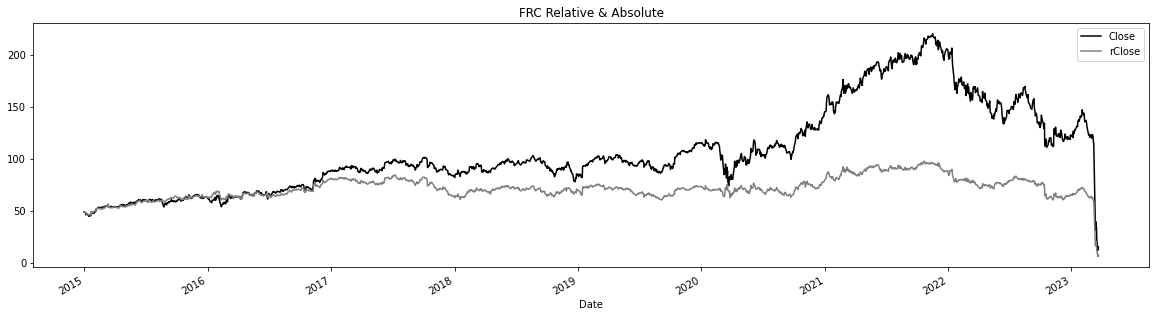

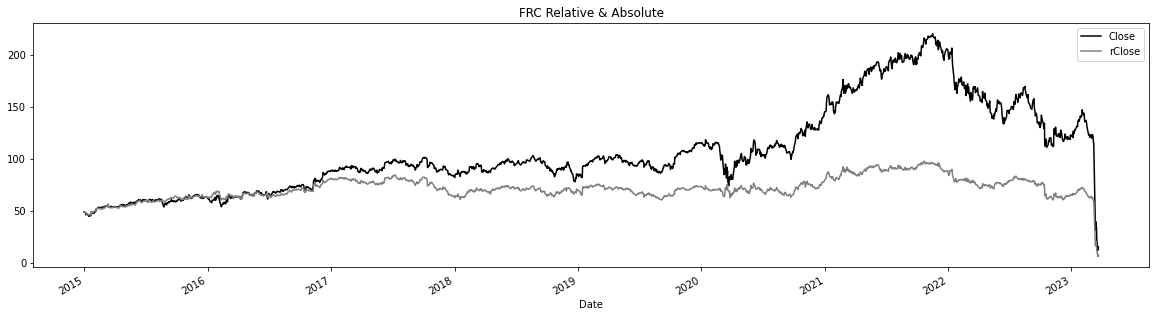

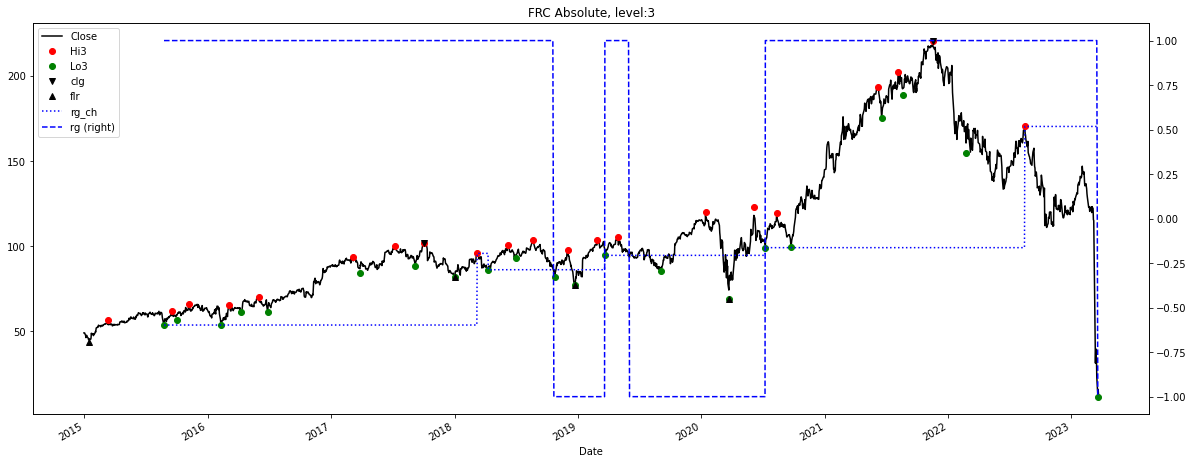

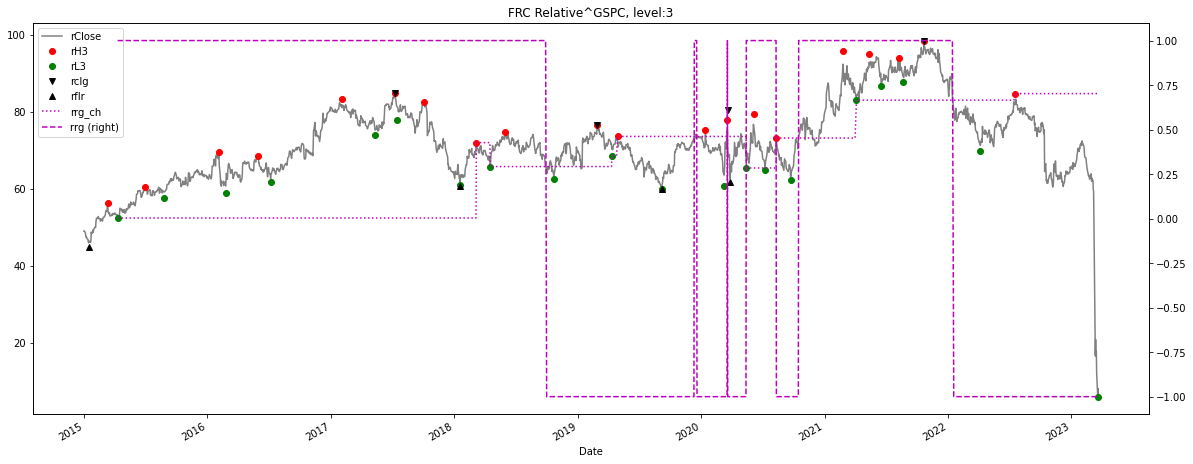

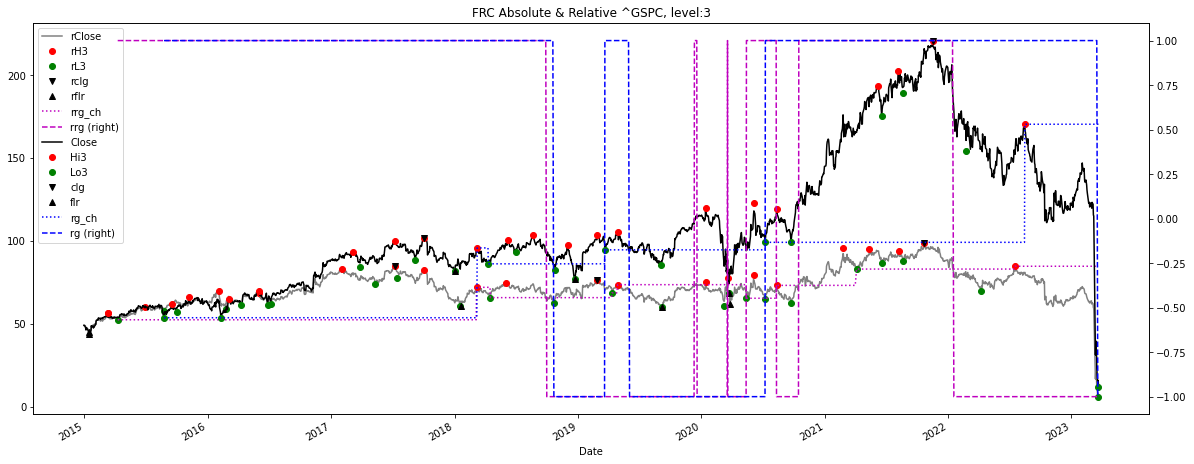

In [14]:
from notes.scanner_engine import swings, regime, lower_upper_OHLC, regime_sma, regime_breakout, turtle_trader

# CHAPTER 5: Regime Definition
ticker = 'FRC'
lvl = 3 # Try different levels to see

df = round(yf.download(tickers= ticker,start= start, end = end,interval = "1d",
                 group_by = 'column',auto_adjust = True, prepost = True, 
                 treads = True, proxy = None),dgt)

swing_opts = {
    'r_vol': r_vol,
    'd_vol': d_vol,
    'dist_pct': dist_pct,
    'lvl': lvl,
    'vlty_n': vlty_n,
    'retrace_pct': retrace_pct,
    'start': start,
    'bm_col': bm_col,
    'bm_df': bm_df
}
regime_opts = {
    'lvl': lvl,
    'vlty_n': vlty_n,
    'threshold': threshold,
}
df = swings(df,rel = False, **swing_opts)
df = regime(df,rel = False, **regime_opts)
df = swings(df,rel = True, **swing_opts)
df = regime(df,rel= True, **regime_opts)
_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)

for a in range(2):    
    df['sma'+str(_c)[:1]+str(st)+str(lt)] = regime_sma(df,_c,st,lt)
    df['bo'+str(_h)[:1]+str(_l)[:1]+ str(slow)] = regime_breakout(df,_h,_l,window)
    df['tt'+str(_h)[:1]+str(fast)+str(_l)[:1]+ str(slow)] = turtle_trader(df, _h, _l, slow, fast)
    _o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
    df[['Close','rClose']].plot(figsize=(20,5),style=['k','grey'],title = str.upper(ticker)+ ' Relative & Absolute')

plot_abs_cols = ['Close','Hi'+str(lvl), 'Lo'+str(lvl),'clg','flr','rg_ch','rg']
plot_abs_style = ['k', 'ro', 'go', 'kv', 'k^','b:','b--']
y2_abs = ['rg']
plot_rel_cols = ['rClose','rH'+str(lvl), 'rL'+str(lvl),'rclg','rflr','rrg_ch','rrg']
plot_rel_style = ['grey', 'ro', 'go', 'kv', 'k^','m:','m--']
y2_rel = ['rrg']
df[plot_abs_cols].plot(secondary_y= y2_abs,figsize=(20,8),
            title = str.upper(ticker)+ ' Absolute, level:'+str(lvl),# grid=True,
            style=plot_abs_style)

df[plot_rel_cols].plot(secondary_y=y2_rel,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Relative'+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style)

df[plot_rel_cols + plot_abs_cols].plot(secondary_y=y2_rel + y2_abs,figsize=(20,8),# grid=True,
            title = str.upper(ticker)+ ' Absolute & Relative '+str.upper(bm_ticker)+', level:'+str(lvl),
            style=plot_rel_style + plot_abs_style)

### Regime combo visualisation
This final block of code plots the data in a more visually appealing way

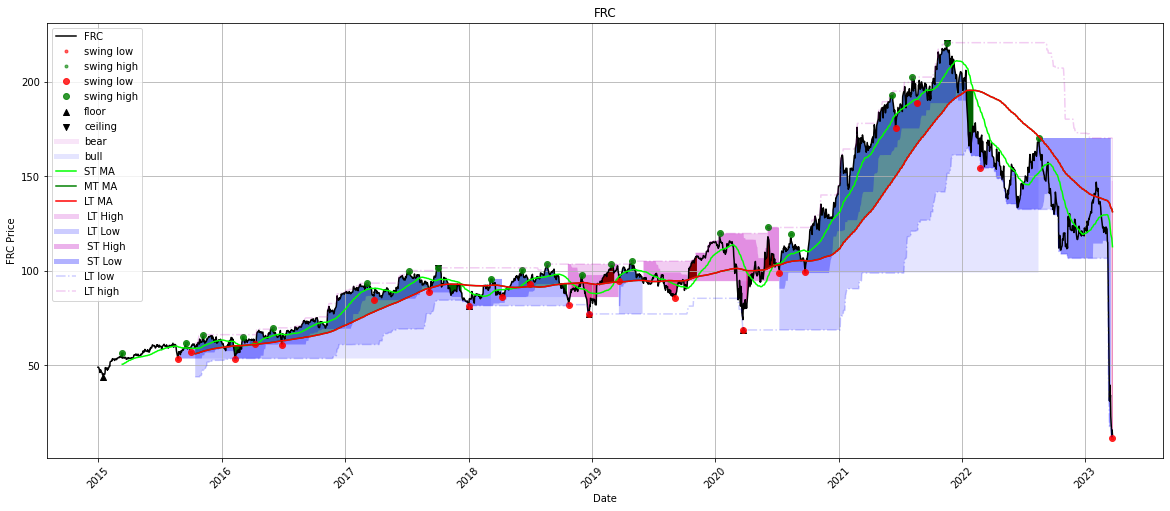

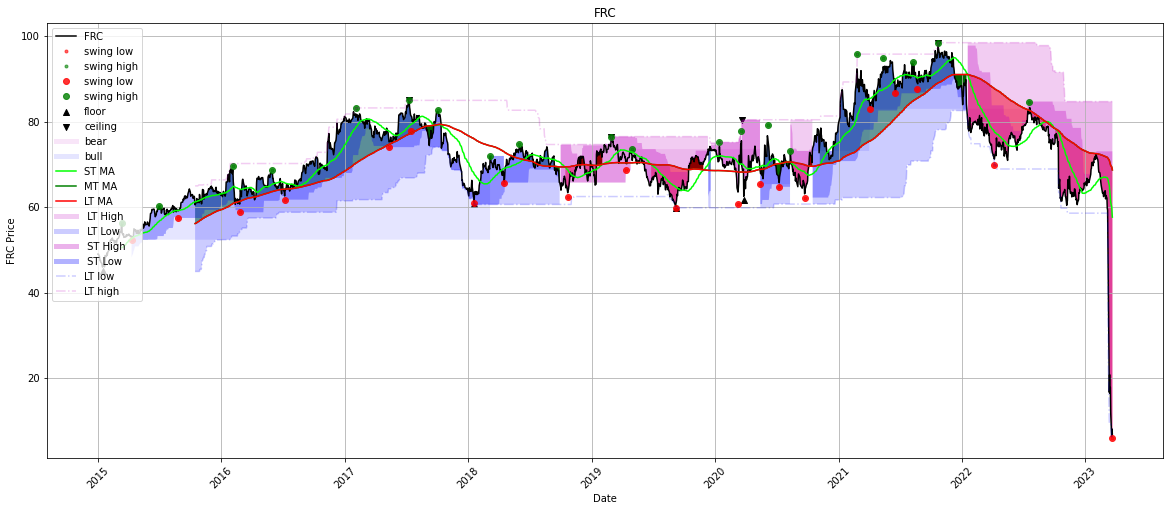

In [15]:
from notes.scanner_engine import graph_regime_combo

# CHAPTER 5: Regime Definition
mav = [fast, slow, 200]
bo = [fast, slow]
# ma_st = ma_mt = ma_lt = lt_lo = lt_hi = st_lo = st_hi = 0

_o,_h,_l,_c = lower_upper_OHLC(df,relative = False)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rg_combo = ['Close','rg','Lo'+str(lvl),'Hi'+str(lvl),'Lo'+str(lvl),'Hi'+str(lvl),'clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)

_o,_h,_l,_c = lower_upper_OHLC(df,relative = True)
ma_st,ma_mt,ma_lt = [df[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [df[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [df[_h].rolling(bo[t]).max() for t in range(len(bo))]

rrg_combo = ['rClose','rrg','rL'+str(lvl),'rH'+str(lvl),'rL'+str(lvl),'rH'+str(lvl),'rclg','rflr','rrg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rrg_combo[r] for r in range(len(rrg_combo)) ]
graph_regime_combo(ticker,df,_c,rg,lo,hi,slo,shi,clg,flr,rg_ch,ma_st,ma_mt,ma_lt,lt_lo,lt_hi,st_lo,st_hi)